<a href="https://colab.research.google.com/github/joshualin24/EEG_demo/blob/main/EEGBCI_Data_Utilities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploration of EEGBCI Motor Movement/Imagery Dataset

This notebook inspects the [EEGBCI dataset](http://www.ncbi.nlm.nih.gov/pubmed/15188875) on [PhysioNet](https://www.ahajournals.org/doi/10.1161/01.CIR.101.23.e215) and provides a few utilities to bridge between the [MNE](https://mne.tools/stable/index.html) neurophysiological data structure and common ML libraries such as Pandas and PyTorch. Detailed data description and experimental protocol can be found [here](https://physionet.org/content/eegmmidb/1.0.0/#files-panel).

# Prerequisite

In [1]:
!pip install pytorch_lightning
!pip install mne

     |████████████████████████████████| 527 kB 6.8 MB/s 
     |████████████████████████████████| 133 kB 51.3 MB/s 
     |████████████████████████████████| 829 kB 67.7 MB/s 
     |████████████████████████████████| 397 kB 66.2 MB/s 
     |████████████████████████████████| 952 kB 48.8 MB/s 
     |████████████████████████████████| 596 kB 57.8 MB/s 
     |████████████████████████████████| 1.1 MB 48.2 MB/s 
     |████████████████████████████████| 271 kB 47.1 MB/s 
     |████████████████████████████████| 144 kB 47.9 MB/s 
     |████████████████████████████████| 94 kB 3.0 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=9a03403cc38d5109968ad3562ef5db0978bc19114a249965a4521581cda4d751
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

     |████████████████████████████████| 7.4 MB 6.7 MB/s 


In [2]:
import mne
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
import pytorch_lightning as pl
import torchaudio
import random
from typing import Optional, Callable
from collections.abc import Sequence

# Data Acquisition

Let's get some example raw data and visualize them.

In [ ]:
SUBJECT = 1
RUNS = [1, 3]

raw_fnames = mne.datasets.eegbci.load_data(SUBJECT, RUNS, path='./')
raw_1 = mne.io.read_raw_edf(raw_fnames[0])  # raw data at rest state
raw_3 = mne.io.read_raw_edf(raw_fnames[1])  # raw data with motor movement

Do you want to set the path:
    /content
as the default EEGBCI dataset path in the mne-python config [y]/n? 
Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [ ]:
raw_1

<RawEDF | S001R01.edf, 64 x 9760 (61.0 s), ~65 kB, data not loaded>

Using matplotlib as 2D backend.


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


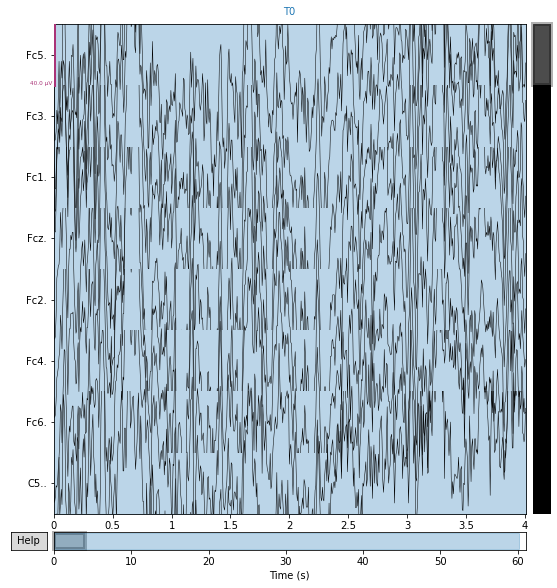

In [ ]:
raw_1.plot(duration=4.0, n_channels=8).show()

In [ ]:
raw_3

<RawEDF | S001R03.edf, 64 x 20000 (125.0 s), ~65 kB, data not loaded>

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


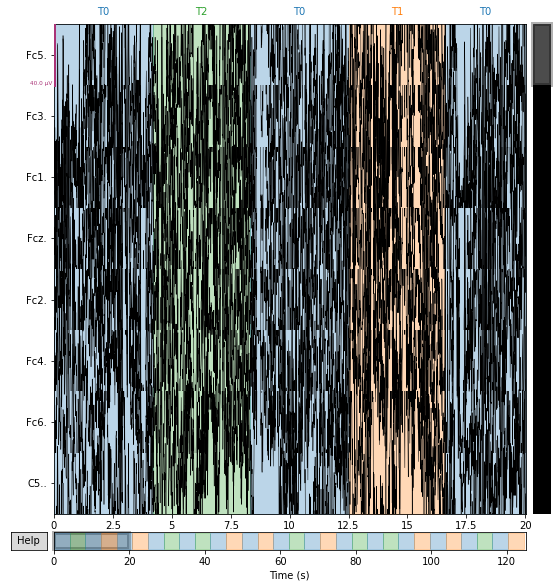

In [ ]:
raw_3.plot(duration=20.0, n_channels=8).show()

# Extract Windows from Raw Data

In [ ]:
EVENT_ID = {  # integer identifier of experimental tasks/events
    'rest/eye-open': 0,
    'rest/eye-closed': 1,
    'movement/left/fist': 2,
    'movement/right/fist': 3,
    'imagery/left/fist': 4,
    'imagery/right/fist': 5,
    'movement/both/fist': 6,
    'movement/both/foot': 7,
    'imagery/both/fist': 8,
    'imagery/both/foot': 9
}
EVENT_MAPPING = {ind: key for key, ind in EVENT_ID.items()}
DURATION = 4  # duration of experimental tasks/events
BASELINE_DURATION = 0.2  # duration of baseline (for drift correction)

The raw data are already annotated by the periods of experimental tasks (varied by different runs), from which we can create the onset events of tasks. **Note that for experimental runs with alternating tasks, we will not consider the rest-state periods in between.**

In [ ]:
event_id = {
    'T1': EVENT_ID['movement/left/fist'],
    'T2': EVENT_ID['movement/right/fist']
}
events, event_id = mne.events_from_annotations(raw_3, event_id=event_id)

Used Annotations descriptions: ['T1', 'T2']


Furthermore, we store some metadata including the start/onset time of tasks, their corresponding integer identifier, subject and run of raw data.

In [ ]:
metadata = pd.DataFrame({
    'start': events[:, 0] / raw_3.info['sfreq'],  # start time of tasks
    'task': events[:, -1],  # identifier of experimental tasks
    'subject': 1,
    'run': 3
})

Now we can extract windows/segments of raw data (so-called "epochs" in the MNE library) with the created events and metadata. By default, **baseline correction is applied** during initiation of the `Epochs` object**, i.e., signal of each channel is subtracted by the mean of a prior baseline segment.**

In [ ]:
epochs = mne.Epochs(
    raw_3,
    events,
    event_id={EVENT_MAPPING[ind]: ind for ind in event_id.values()},
    tmin=-BASELINE_DURATION,
    tmax=DURATION,
    metadata=metadata
)

Adding metadata with 4 columns
Replacing existing metadata with 4 columns
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


After baseline correction, we discard the baseline segments and keep the remaining windows for future machine learning analyses.

In [ ]:
epochs.load_data().crop(tmin=0.0)

Loading data for 15 events and 673 original time points ...
0 bad epochs dropped


Number of events,15
Events,movement/left/fist: 8movement/right/fist: 7
Time range,0.000 – 4.000 sec
Baseline,-0.200 – 0.000 sec


The `Epochs` object also support nice keyword parsing from the event name:

In [ ]:
epochs['left']  # parse windows associated with left fist

Number of events,8
Events,movement/left/fist: 8
Time range,0.000 – 4.000 sec
Baseline,-0.200 – 0.000 sec


A naive visualization:

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


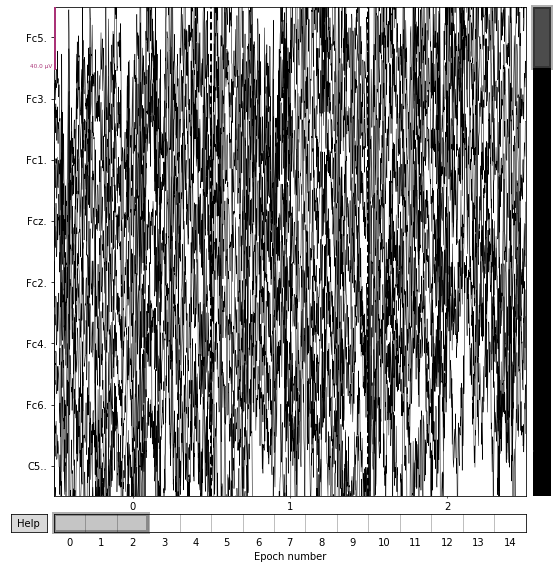

In [ ]:
epochs.plot(n_epochs=3, n_channels=8).show()

In the case of constant rest-state experimental runs, `Epochs` object with a fixed duration can also be easily created (although no baseline correction is applied).

In [ ]:
fixed_length_epochs = mne.make_fixed_length_epochs(raw_1, duration=4.0, id=0)

Not setting metadata
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated


Loading data for 15 events and 640 original time points ...
0 bad epochs dropped
Loading data for 15 events and 640 original time points ...
Loading data for 3 events and 640 original time points ...


/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


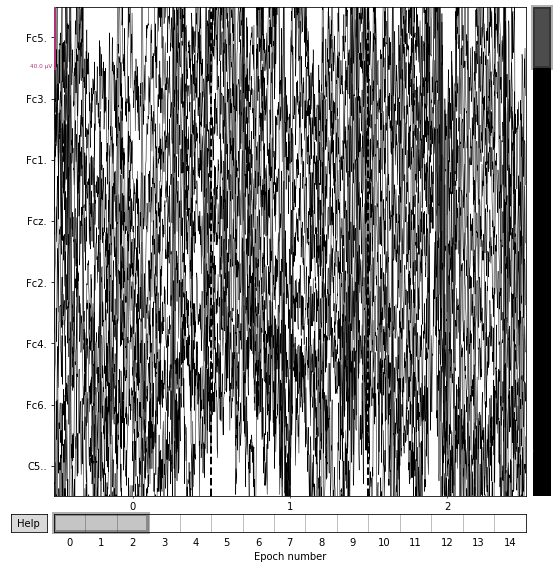

<bound method Figure.show of <MNEBrowseFigure size 576x576 with 4 Axes>>

In [ ]:
fixed_length_epochs.plot(n_epochs=3, n_channels=8).show

# Utilities

## Dataset

In [ ]:
def extract_windows(
    raw: mne.io.Raw,
    subject: int,
    run: int,
    event_id: dict,
    duration: float = 4.0,
    baseline_duration: float = 0.2
):
    """
    Return windows/epochs extracted from raw data.

    Arguments
    ---------
    raw: Raw data
    subject: Subject of recording
    run: Experimental run
    event_id: Mapping from tasks/events to integer identifiers
    duration: duration of windows that capture responses to tasks/events
    baseline_duration: duration of baseline for drift correction
    
    Note
    ----
    Baseline segments are not discarded from the returned windows.
    """
    events, focal_event_id = get_events(raw, run, event_id)
    metadata = pd.DataFrame({
        'start': events[:, 0] / raw.info['sfreq'],  # start time of tasks
        'task': events[:, -1],  # identifier of experimental tasks
        'subject': subject,
        'run': run
    })
    event_mapping = {ind: key for key, ind in event_id.items()}
    return mne.Epochs(
        raw,
        events,
        event_id={event_mapping[ind]: ind for ind in focal_event_id.values()},
        tmin=-baseline_duration,
        tmax=duration,
        metadata=metadata
    )


def get_events(
    raw: mne.io.Raw,
    run: int,
    event_id: dict,
    fixed_length_duration: float = 4.0
):
    """
    Return tuple of events and their integer-identifier-mapping according to
    the experimental run.

    Argmuments
    ----------
    raw: Raw data
    run: Experimental run
    event_id: Mapping from tasks/events to integer identifiers
    fixed_length_duration: Duration to create fixed-length events

    Note
    ----
    For runs with alternating experimental tasks, the rest-state periods in
    between will not be considered.
    """
    if run in (1, 2):
        events = mne.make_fixed_length_events(
            raw,
            id=run,
            duration=fixed_length_duration
        )
        return events, {'T0': run}
    elif run in (3, 7, 11):
        event_id = {
            'T1': event_id['movement/left/fist'],
            'T2': event_id['movement/right/fist']
        }
        return mne.events_from_annotations(raw, event_id=event_id)
    elif run in (4, 8, 12):
        event_id = {
            'T1': event_id['imagery/left/fist'],
            'T2': event_id['imagery/right/fist']
        }
        return mne.events_from_annotations(raw, event_id=event_id)
    elif run in (5, 9, 13):
        event_id = {
            'T1': event_id['movement/both/fist'],
            'T2': event_id['movement/both/foot']
        }
        return mne.events_from_annotations(raw, event_id=event_id)
    elif run in (6, 10, 14):
        event_id = {
            'T1': event_id['imagery/both/fist'],
            'T2': event_id['imagery/both/foot']
        }
        return mne.events_from_annotations(raw, event_id=event_id)
    else:
        raise ValueError('invalid experimental run.')

In [ ]:
EVENT_ID = {  # integer identifier of experimental tasks/events
    'rest/eye-open': 0,
    'rest/eye-closed': 1,
    'movement/left/fist': 2,
    'movement/right/fist': 3,
    'imagery/left/fist': 4,
    'imagery/right/fist': 5,
    'movement/both/fist': 6,
    'movement/both/foot': 7,
    'imagery/both/fist': 8,
    'imagery/both/foot': 9
}


def eegbci_epochs(
    subjects: list,
    runs: list,
    dir: str = './',
    select: Optional[str] = None,
    **kwargs
):
    """
    Return extracted windows/epochs from the EEGBCI motor movement/imagery data.

    Arguments
    ---------
    subjects: List of subjects of interest
    runs: List of experimental runs for each subject
    dir: Root directory path to the EEGBCI data
    select: Key to select a part of extracted windows/epochs
    kwargs: Keyword arguments passed to extract windows
    
    Note
    ----
    Baseline segments are not discarded from the returned windows.
    """
    epochs_list = [
        extract_windows(
            mne.io.read_raw_edf(mne.datasets.eegbci.load_data(subject, run, path=dir)[0]),
            subject,
            run,
            EVENT_ID,
            **kwargs
        ) for subject in subjects for run in runs
    ]
    epochs = mne.concatenate_epochs(epochs_list, add_offset=False)
    return epochs if select is None else epochs[select]

In [ ]:
def eegbci_dataframe(subjects: list, runs: list, **kwargs):
    """
    Return dataframe and metadata of extracted windows from the EEGBCI motor
    movement/imagery data.

    Arguments
    ---------
    subjects: List of subjects of interest
    runs: List of experimental runs for each subject
    kwargs: Keyword arguments passed to extract 
    
    Note
    ----
    Baseline segments are discarded from the returned windows.
    """
    epochs = eegbci_epochs(subjects, runs, **kwargs)
    epochs.load_data().crop(tmin=0.0)  # discard baseline segments
    return epochs.to_data_frame(), epochs.metadata

In [ ]:
class EEGBCIDataset(Dataset):
    """Dataset of the EEGBCI motor movement/imagery data."""

    def __init__(
        self,
        subjects: list,
        runs: list,
        get_label: Callable,
        transform: Callable = None,
        target_transform: Callable = None,
        **kwargs
    ):
        """
        Arguments
        ---------
        subjects: List of subjects of interest
        runs: List of experimental runs for each subject
        get_label: Function to extract label from metadata
        transform: Transformation upon data
        target_transform: Transformation upon labels
        kwargs: Keyword arguments passed to extract windows
        
        Note
        ----
        Baseline segments are discarded from the returned windows.
        """
        super().__init__()
        self.windows = eegbci_epochs(subjects, runs, **kwargs)
        self.get_label = get_label
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, ind: int):
        window = self.windows[ind]
        data = window.get_data(tmin=0.0)[0]  # baseline segment discarded
        if self.transform: data = self.transform(data)
        label = self.get_label(window.metadata)
        if self.target_transform: label = self.target_transform(label)
        return data, label

## Augmentations

In [ ]:
class DCShift:
    """Add a random constant shift to data."""

    def __init__(self, min_shift: float, max_shift: float):
        self.base = min_shift
        self.scale = max_shift - min_shift

    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        shifts = self.base + self.scale * torch.rand_like(data[..., :1])
        return data + shifts

In [ ]:
class AmplitudeScale:
    """Scale data with a randomly selected constant."""

    def __init__(self, min_scale: float, max_scale: float):
        self.base = min_scale
        self.scale = max_scale - min_scale

    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        scales = self.base + self.scale * torch.rand_like(data[..., :1])
        return data * scales

In [ ]:
class AdditiveGaussianNoise:
    """Add Gaussian noise with a random standard deviation."""

    def __init__(self, min_sigma: float, max_sigma: float):
        self.base = min_sigma
        self.scale = max_sigma - min_sigma

    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        sigmas = self.base + self.scale * torch.rand_like(data[..., :1])
        return data + torch.randn_like(data) * sigmas

In [ ]:
class TimeMasking:
    """Mask data for a randomly selected time segment."""

    def __init__(self, min_len: int, max_len: int, mask_val: float = 0.0):
        self.base = min_len
        self.scale = max_len - min_len
        self.val = mask_val
    
    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        lens = self.base + self.scale * torch.rand_like(data[..., :1])
        starts = (data.size(-1) - lens) * torch.rand_like(data[..., :1])
        ends = starts + lens
        inds = torch.arange(data.size(-1), dtype=data.dtype, device=data.device)
        return data.masked_fill((inds >= starts) & (inds < ends), self.val)

In [ ]:
class TimeShift:
    """Shift data along the time axis with a periodic boundary condition."""

    def __init__(self, min_shift: int, max_shift: int):
        self.base = min_shift
        self.scale = max_shift - min_shift
    
    def __call__(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        shifts = self.base + self.scale * torch.rand_like(data[..., :1])
        shifts = torch.remainder(shifts, data.size(-1))
        # Prepare indices for masking
        inds = torch.arange(data.size(-1), dtype=data.dtype, device=data.device)
        inds_rev = data.size(-1) - 1 - inds
        # Allocate and fill in shifted data
        shifted = torch.empty_like(data)
        shifted[inds < shifts] = data[inds_rev < shifts]
        shifted[inds >= shifts] = data[inds_rev >= shifts]
        return shifted

In [ ]:
class BandStopFilter:
    """Filter out data for a frequency band."""

    def __init__(self, min_freq, max_freq, bandwidth, sample_rate):
        self.base = min_freq
        self.scale = max_freq - min_freq
        self.bandwidth = bandwidth
        self.sample_rate = sample_rate

    def __call_(self, data: torch.Tensor):
        """Data must have dimensions `(..., time steps)`."""
        central_freqs = self.base + self.scale * torch.rand_like(data[..., :1])
        return torchaudio.functional.bandreject_biquad(
            data,
            self.sample_rate,
            central_freqs,
            central_freqs / self.bandwidth
        )

In [ ]:
class RandomAugmentationPair:
    """Randomly selected pair of augmentations from a given collection."""

    def __init__(self, augmentations: Sequence):
        self.augs = augmentations
    
    def __call__(self, data: torch.Tensor):
        """Return tuple of augmented data."""
        aug_1, aug_2 = random.sample(self.augs, 2)
        return aug_1(data), aug_2(data)

## Model Architectures

## Self-Supervised Learning Frameworks

### SeqCLR (adopted from SimCLR)

See reference [here](https://proceedings.mlr.press/v136/mohsenvand20a.html):

Mohsenvand, M.N., Izadi, M.R. &amp; Maes, P.. (2020). Contrastive Representation Learning for Electroencephalogram Classification. <i>Proceedings of the Machine Learning for Health NeurIPS Workshop</i>, in <i>Proceedings of Machine Learning Research</i> 136:238-253

In [ ]:
class ContrastiveLoss(nn.Module):
    """
    Constrative loss function in the SimCLR framework.

    Notes
    -----
    1. Full credit to https://zablo.net/blog/post/understanding-implementing-simclr-guide-eli5-pytorch/.
    2. See also Chen, Ting, et al. "A simple framework for contrastive learning
       of visual representations." International conference on machine learning.
       PMLR, 2020.
    """

    def __init__(self, batch_size: int, temperature: float = 0.5):
        """
        Arguments
        ---------
        batch_size: Batch size (as well as the size of candidate pool)
        temperature: Parameter of sharpness
        """
        super().__init__()
        self.batch_size = batch_size
        self.register_buffer("temperature", torch.tensor(temperature))
        self.register_buffer(
            "negatives_mask",
            (~torch.eye(batch_size*2, batch_size*2, dtype=bool)).float()
        )
            
    def forward(self, emb_i: torch.Tensor, emb_j: torch.Tensor):
        """
        Return the Boltzmann distribution of positive pairs, where the energy
        function is the cosine similarity between embeddings.
        """
        z_i = torch.nn.functinal.normalize(emb_i, dim=1)
        z_j = torch.nn.functinal.normalize(emb_j, dim=1)
        representations = torch.cat([z_i, z_j], dim=0)
        # Compute cosine similarity between positive pairs
        similarity_matrix = torch.nn.functinal.cosine_similarity(
            representations.unsqueeze(1),
            representations.unsqueeze(0),
            dim=2
        )
        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)
        positives = torch.cat([sim_ij, sim_ji], dim=0)
        # Compute loss value
        nominator = torch.exp(positives / self.temperature)
        denominator = self.negatives_mask * torch.exp(similarity_matrix / self.temperature)
        loss_partial = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(loss_partial) / (2 * self.batch_size)
        return loss

In [ ]:
class SeqCLR(pl.LightningModule):
    """Contrastive learning on individual channels of EEG data."""

    def __init__(
        self,
        encoder: nn.Module,
        projector: nn.Module,
        augmentations: Sequence,
        batch_size: int,
        temperature: float = 5e-2,
        learning_rate: float = 1e-4,
        weight_decay: float = 1e-4
    ):
        """
        Arguments
        ---------
        encoder: Encoder module that extract representation from data
        projector: Projection head module
        augmentations: Collection of augmentations of interests
        batch_size: Batch size of training/validation set
        temperature: Temperature of contrastive loss
        learning_rate: Learning rate of optimizer
        weight_decay: Weight decay of optimizer
        """
        super().__init__()
        self.encoder = encoder
        self.projector = projector
        self.augmentation_pair = RandomAugmentationPair(augmentations)
        self.criterion = ContrastiveLoss(batch_size, temperature)
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
    
    def forward(self, data: torch.Tensor):
        """
        Return the learned representation of data.

        Note
        ----
        Data must have dimensions `(batch, channels, ..., time steps)`.
        """
        repr = self.encoder(data.flatten(end_dim=1))
        return repr.unflatten(0, data.size()[:2])
    
    def training_step(self, batch, batch_ind):
        loss = self._shared_step(batch, batch_ind)
        self.log('Train/Loss', loss)
        return loss
    
    def validation_step(self, batch, batch_ind):
        loss = self._shared_step(batch, batch_ind)
        self.log('Validation/Loss', loss)
    
    def _shared_step(self, batch, batch_ind):
        """Return loss of the current batch."""
        data, = batch
        data = data.flatten(end_dim=1)  # flatten channels into the batch
        augmented_1, augmented_2 = self.augmentation_pair(data)
        loss = self.criterion(
            self.projector(self.encoder(augmented_1)),
            self.projector(self.encoder(augmented_2))
        )
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        return optimizer

### DINO

See reference [here](https://openaccess.thecvf.com/content/ICCV2021/html/Caron_Emerging_Properties_in_Self-Supervised_Vision_Transformers_ICCV_2021_paper.html):

Mathilde Caron, Hugo Touvron, Ishan Misra, Hervé Jégou, Julien Mairal, Piotr Bojanowski, Armand Joulin; Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV), 2021, pp. 9650-9660

In [ ]:
class StudentTeacherLoss(nn.Module):
    """Cross-entropy loss between student and teacher outputs after softmax."""

    def __init__(
        self,
        dim: int,
        num_std_augs: int,
        num_tch_augs: int,
        student_temperature: float,
        teacher_temperature: float,
        momentum: float = 0.9
    ):
        """
        Arguments
        ---------
        dim: Output dimension of student/teacher module
        num_std_augs: Number of augmentations passed to student module
        num_tch_augs: Number of augmentations passed to teacher module
        student_temperature: Sharpness parameter for student output
        teacher_temperature: Sharpness parameter for teacher output
        momentum: Update rate parameter of center buffer
        """
        super().__init__()
        self.register_buffer('center', torch.zeros(dim))
        self.register_buffer(
            'mask',
            (~torch.eye(num_tch_augs, num_std_augs, dtype=bool)).float()
        )
        self.std_tpr = student_temperature
        self.tch_tpr = teacher_temperature
        self.momentum = momentum

    def forward(self, std_out: torch.Tensor, tch_out: torch.Tensor):
        """
        Arguments
        ---------
        std_out: Output of student module
        tch_out: Output of teacher module

        Note
        ----
        Output of student/teacher module must have dimension
        `(batch, augmentations, projection/embedding)`.
        """
        mask = self.mask  # to exclude same augmentation in student/teacher
        for _ in range(len(std_out.size())-2): mask = mask.unsqueeze(-1)
        tch_prob = torch.nn.functional.softmax(
            (tch_out - self.center) / self.tch_tpr,
            dim=-1
        ).unsqueeze(2)
        std_log_prob = torch.nn.functional.log_softmax(
            std_out / self.std_tpr,
            dim=-1
        ).unsqueeze(1)
        loss = (-mask * tch_prob * std_log_prob).flatten(start_dim=1).sum(1)
        self.update_center(tch_out)
        return loss
    
    @torch.no_grad()
    def update_center(self, tch_out: torch.Tensor):
        """Update center buffer used for teacher output."""
        self.center *= self.momentum
        self.center += (1 - self.momentum) * tch_out.flatten(end_dim=-2).mean(0)

In [ ]:
class DINO(pl.LightningModule):
    """Self-supervised learning motivated by knowledge distillation."""

    def __init__(
        self,
        student: nn.Module,
        teacher: nn.Module,
        student_head: nn.Module,
        teacher_head: nn.Module,
        common_augs: tuple,
        std_exclusive_augs: tuple,
        projection_dim: int,
        student_temperature: float,
        teacher_temperature: float,
        teacher_momentum: float,
        center_momentum: float,
        learning_rate: float,
        weight_decay: float
    ):
        """
        Arguments
        ---------
        student: Encoder of student module
        teacher: Encoder of teacher module
        student_head: Projection head of student module
        teacher_head: Projection head of teacher module
        common_augs: Augmentations passed to both student and teacher modules
        std_exclusive_augs: Augmentations passed to student module only
        projection_dim: Output dimension of projection head
        student_temperature: Sharpness parameter for student output
        teacher_temperature: Sharpness parameter for teacher output
        teacher_momentum: Update rate parameter of teacher module
        center_momentum: Update rate parameter of dummy centers
        learning_rate: Learning rate of student module
        weight_decay: Weight decay when training student module

        Notes
        -----
        1. `teacher`/`teacher_head` must have the same architecture as
           `student`/`student_head`.
        2. `common_augs` and `std_exclusive_augs` should be mutually exclusive.
        3. `projection_dim` must match the dimension of output of
           `student_head`/`teacher_head`.
        """
        super().__init__()
        self.student = nn.Sequential(student, student_head)
        self.teacher = nn.Sequential(teacher, teacher_head)
        self.encoder = teacher
        self.std_augs = common_augs + std_exclusive_augs
        self.tch_augs = common_augs
        self.momentum = teacher_momentum
        self.criterion = StudentTeacherLoss(
            projection_dim,
            len(self.std_augs),
            len(self.tch_augs),
            student_temperature,
            teacher_temperature,
            center_momentum
        )
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        # Force teacher and student module to start with the same weights
        self.teacher.load_state_dict(self.student.state_dict())
        # Disable gradient tracking for teacher module
        for p in self.teacher.parameters(): p.requires_grad_(False)

    def forward(self, data: torch.Tensor):
        """Return the learned representation of data."""
        return self.encoder(data)
    
    def training_step(self, batch, batch_ind):
        # Manually update student module
        opt = self.optimizers()
        opt.zero_grad()
        loss = self._shared_step(batch, batch_ind)
        loss.manual_backward()
        opt.step()
        # Update teacher module with exponential moving average
        for p_tch, p_std in zip(
            self.teacher.parameters(),
            self.student.parameters()
        ):
            p_tch.mul_(self.momentum).add_(p_std.detach(), alpha=1.0-self.momentum)
        # Log metric
        self.log('Train/Loss', loss)
        return loss
    
    def validation_step(self, batch, batch_ind):
        loss = self._shared_step(batch, batch_ind)
        self.log('Validation/Loss', loss)
    
    def _shared_step(self, batch, batch_ind):
        """Return loss of the current batch."""
        data, = batch
        augmented_std = torch.cat(  # with dimension (batch, augmentation, ...)
            [aug(data) for aug in self.std_augs],
            dim=1
        ).unflatten(1, (len(self.std_augs), -1))
        augmented_tch = torch.cat(  # with dimension (batch, augmentation, ...)
            [aug(data) for aug in self.tch_augs],
            dim=1
        ).unflattn(1, (len(self.tch_augs), -1))
        loss = self.criterion(
            self.student(augmented_std),
            self.teacher(augmented_tch).deteach()
        )
        return loss
    
    def configure_optimizers(self):
        opt = torch.optim.AdamW(  # optimizer to train student module
            self.student.parameters(),
            lr=self.learning_rate,
            weight_decay=self.weight_decay
        )
        return opt

# Scratch

In [ ]:
temp_dataset = EEGBCIDataset([1], [1, 3], lambda meta: meta['task'].values[0])

Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Extracting EDF parameters from /content/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Used Annotations descriptions: ['T1', 'T2']
Adding metadata with 4 columns
Replacing existing metadata with 4 columns
15 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 15 events and 673 original time points ...
1 bad epochs dropped
Loading data for 15 events and 673 original time points ...
0 bad epochs dropped
Load

<ipython-input-22-18904047ebcb>:46: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.concatenate_epochs(epochs_list, add_offset=False)


In [ ]:
data, label = temp_dataset[2]
print(f'Data of shape {data.shape}: \n', data)
print('Label: \n', label)

Data of shape (64, 641): 
 [[-8.48484848e-06 -2.74848485e-05 -1.34848485e-05 ... -1.44848485e-05
   3.65151515e-05  7.55151515e-05]
 [-1.06666667e-05 -2.56666667e-05 -1.06666667e-05 ... -4.66666667e-06
   4.13333333e-05  7.13333333e-05]
 [-2.25151515e-05 -3.55151515e-05 -2.05151515e-05 ... -1.05151515e-05
   3.34848485e-05  6.94848485e-05]
 ...
 [-1.51515152e-05 -3.15151515e-06  2.84848485e-06 ...  1.48484848e-05
   4.08484848e-05  6.08484848e-05]
 [-6.40303030e-05 -5.00303030e-05 -4.40303030e-05 ...  3.89696970e-05
   5.89696970e-05  7.79696970e-05]
 [-4.00000000e-06  2.00000000e-06  3.00000000e-06 ...  3.20000000e-05
   6.10000000e-05  9.30000000e-05]]
Label: 
 1
